In [1]:
import torch
import networkx as nx

from dgl.data import MiniGCDataset, QM9Dataset

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from collections import Counter
from pprint import pprint

from auxiliary import Datasets
from auxiliary.GNNModels import GNNInvariant, GNNEquivariant2D

# Molecular Dataset

The [QM9-dataset](https://docs.dgl.ai/generated/dgl.data.QM9Dataset.html#dgl.data.QM9Dataset) - obtained through the Deep Graph Library (DGL) - is a dataset for graph property prediction. The dataset consists of 130.831 graphs each associated with 12 regression targets.

## Loading the Molecular dataset

For loading the molecular dataset, the regression targets of interest is required as an input. Obviously, a classification task can trivially be created by thresholding continuous attributes, such as the regression targets. This will hence be done, for being comparable with the benchmarking done on synthetic datasets.

In [2]:
data = QM9Dataset(label_keys=['mu'])

### Time tests

First, let's investigate the smarter way to load the data as a `GraphDataset`-object. We evaluate the running time by comparing a `jit`-based function before defining the actual dataset.

In [3]:
from numba import jit

def get_label(data, num_):
    res = np.empty(num_, dtype=np.float64)
    node_coords = torch.tensor([])
    node_graph_index = torch.tensor([])
    edge_list = torch.tensor([])
    
    for i in range(num_):
        g, label = data[i]
        
        res[i] = label.item()
        node_coords = torch.concat([node_coords, g.ndata['R']])
        node_graph_index = torch.concat([node_graph_index, i * torch.ones([node_coords.__len__()])])
        
        node_from, node_to = g.edges(form='uv')
        edge_list = torch.concat([edge_list, torch.tensor(list(zip(node_from, node_to)))])
        
    graph_list = torch.tensor(res > res.mean())
    return node_coords, node_graph_index, graph_list, edge_list

@jit(forceobj=True)
def get_label_jit(data, num_):
    res = np.empty(num_, dtype=np.float64)
    
    node_coords = torch.tensor([])
    node_graph_index = torch.tensor([])
    edge_list = torch.tensor([])
    
    for i in range(num_):
        g, label = data[i]
        
        res[i] = label.item()
        node_coords = torch.concat([node_coords, g.ndata['R']])
        node_graph_index = torch.concat([node_graph_index, i * torch.ones([node_coords.__len__()])])
        
        node_from, node_to = g.edges(form='uv')
        edge_list = torch.concat([edge_list, torch.stack(g.edges()).T])
        
    graph_list = torch.tensor(res > res.mean())
    return node_coords, node_graph_index.to(torch.long), graph_list.to(torch.long), edge_list.to(torch.long)

In [4]:
# jit-version
%timeit get_label_jit(data, 100)

205 ms ± 10.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [5]:
# regular version
%timeit get_label(data, 100)

231 ms ± 35.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Visualizing the Molecular dataset

In [6]:
# Define parameters
label = 'U' # Internal energy at 298.15 K
num_graphs = 10

# Create data
data = Datasets.Molecular(num_graphs, label)

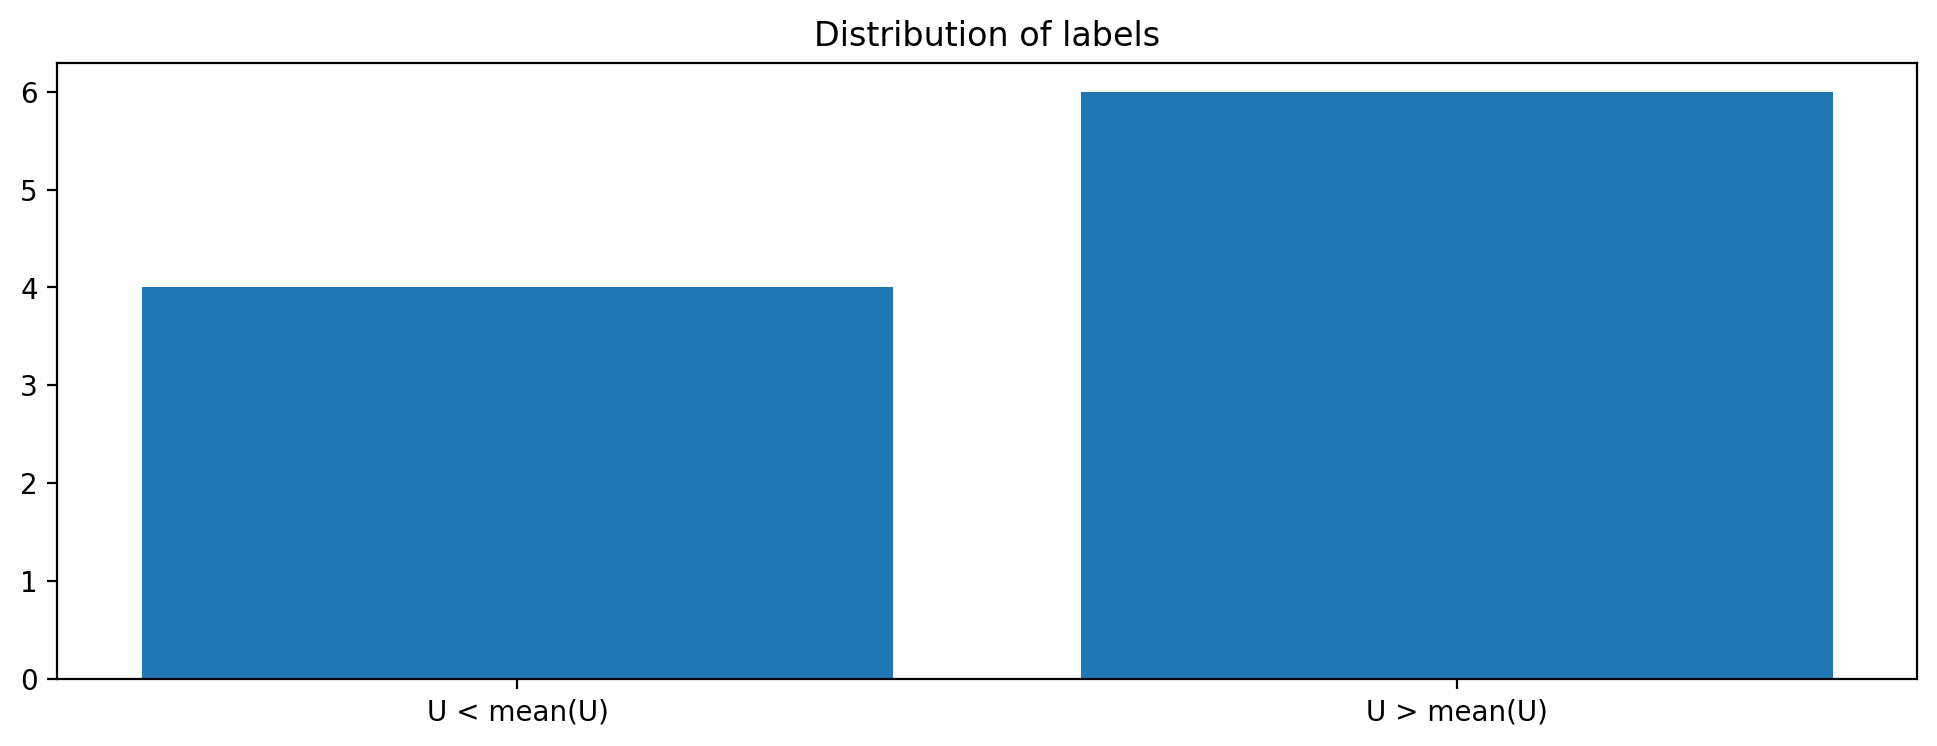

In [7]:
# Counts
counts = Counter(data.graph_list.numpy())

# Plot figure
fig = plt.figure(figsize=((12, 4)), dpi=200)
plt.bar(counts.keys(), counts.values())
plt.xticks(np.arange(counts.keys().__len__()), [f"{label} < mean({label})", f"{label} > mean({label})"])
plt.title("Distribution of labels")
plt.show()

In [8]:
def _format_axes(ax):
        """Visualization options for the 3D axes."""
        # Turn gridlines off
        ax.grid(False)
        # Suppress tick labels
        for dim in (ax.xaxis, ax.yaxis, ax.zaxis):
            dim.set_ticks([])
        # Set axes labels
        ax.set_xlabel("x")
        ax.set_ylabel("y")
        ax.set_zlabel("z")
        
def draw_3D(node_xyz, edge_xyz, ax):
    # Plot the nodes - alpha is scaled by "depth" automatically
    ax.scatter(*node_xyz.T, s=100, ec="w")

    # Plot the edges
    for vizedge in edge_xyz:
        ax.plot(*vizedge.T, color="tab:gray")

    _format_axes(ax)    

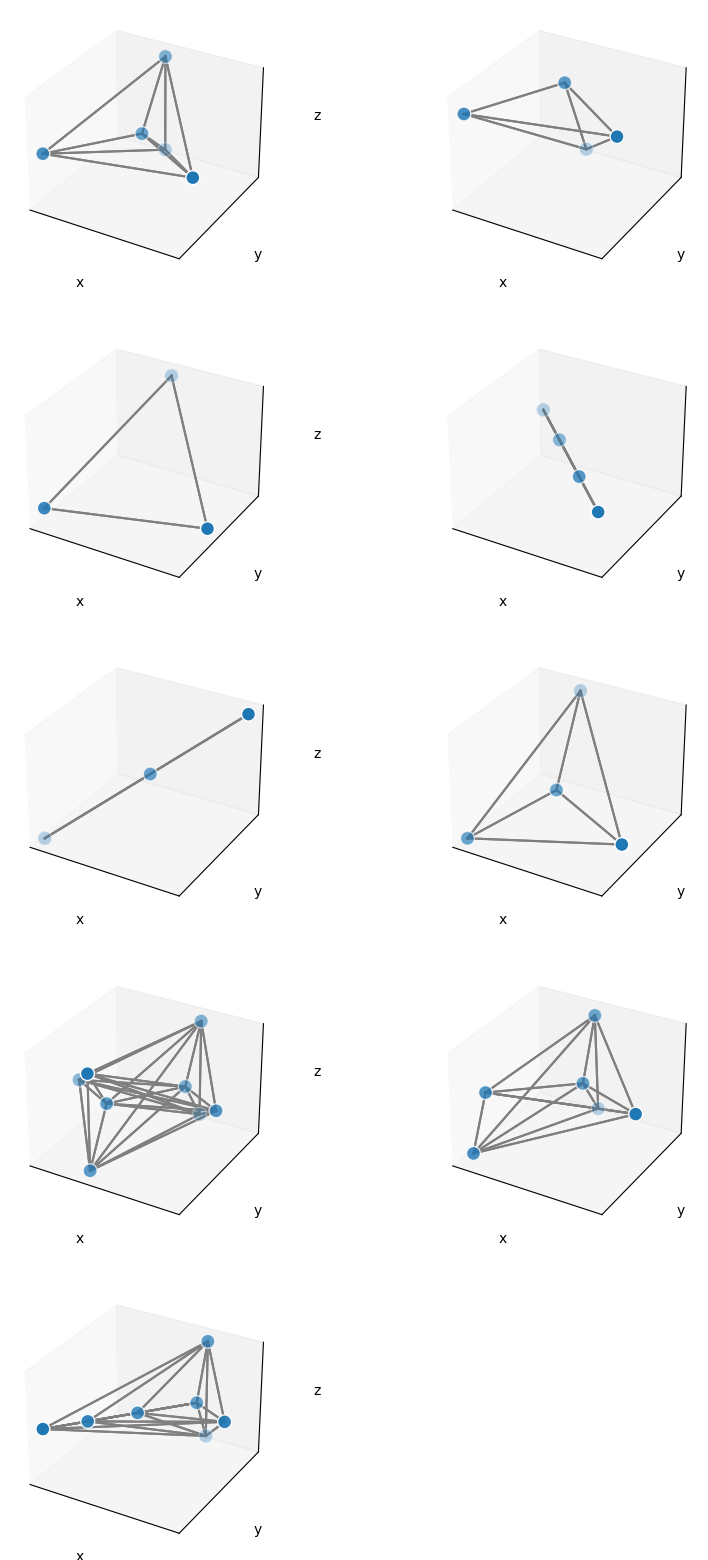

In [9]:
# Create data
data.center().rotate(torch.pi/4, axis=2)

# Plot the dataset
nrows, ncols = 5, 2
fig = plt.figure(figsize=(10,20))
for i in range(data.num_graphs):
    if i+1 >= 10:
        break
        
    ax_index = int(str(f"{nrows}{ncols}{i+1}"))
    ax = fig.add_subplot(ax_index, projection="3d")

    edges = data.edge_list[data.edge_graph_index == i].tolist()
    nodes = np.arange(data.num_nodes)[data.node_graph_index == i]
    
    G = nx.DiGraph()
    G.add_edges_from(edges)
    pos = dict(zip(nodes, data.node_coordinates[nodes].tolist()))
    
    node_xyz = np.array([pos[v] for v in sorted(G)])
    edge_xyz = np.array([(pos[u], pos[v]) for u, v in G.edges()])
        
    draw_3D(node_xyz, edge_xyz, ax)
    

In [10]:
data = Datasets.Molecular(1000, 'U')

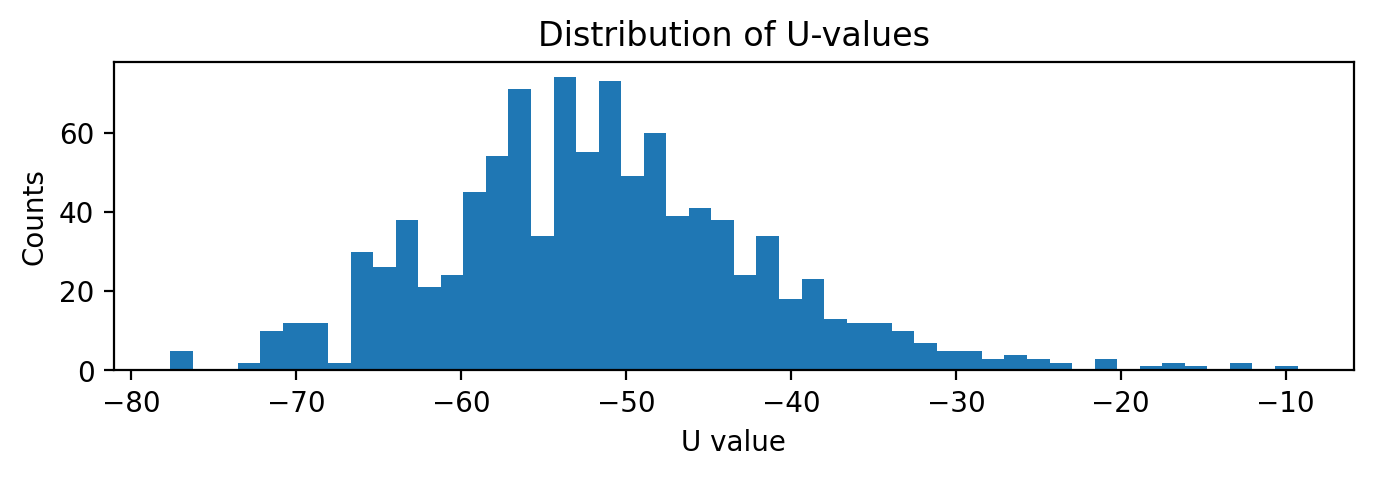

In [11]:
fig = plt.figure(figsize=((8, 2)), dpi=200)
plt.hist(torch.tensor(data.regression_target).numpy(), bins=50)
plt.title(f"Distribution of {label}-values")
plt.xlabel(f"{label} value")
plt.ylabel("Counts")
plt.show()

## Train Invariant GNN

In [18]:
# Network, loss function, and optimizer
net = GNNInvariant(output_dim=2, state_dim = 5)
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.01)

In [19]:
epochs = 100
lss = np.zeros(epochs)
acc = np.zeros(epochs)

with trange(epochs) as t:
    for epoch in t:
        optimizer.zero_grad()
        output = net(data)
        loss = loss_function(output, data.graph_list)
        loss.backward()
        optimizer.step()
        
        accuracy = (torch.argmax(output, 1) == data.graph_list).sum() / data.num_graphs
        t.set_description_str(\
             f'Loss: {loss.detach().numpy():.3f}, \
               Accuracy: {accuracy*100:.0f}%, Progress')
        
        lss[epoch] = loss
        acc[epoch] = accuracy


  0%|          | 0/100 [00:00<?, ?it/s]

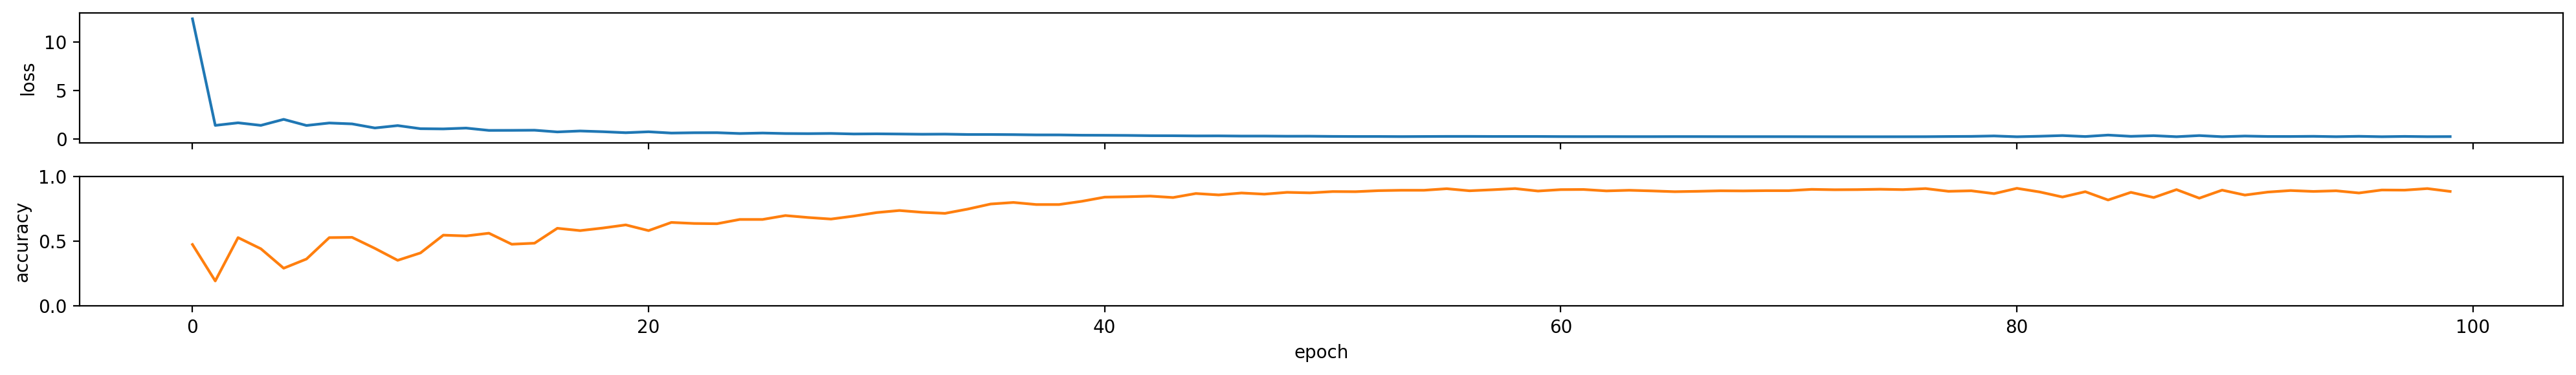

In [20]:
fig, ax = plt.subplots(2, 1, figsize=((20, 3)), sharex=True, dpi=200)
ax[0].plot(np.arange(epochs), lss, color='C0')
ax[1].plot(np.arange(epochs), acc, color='C1')

ax[0].set_ylabel("loss")
ax[1].set_ylabel("accuracy")
ax[1].set_xlabel('epoch')

ax[1].set_ylim([0, 1])

plt.tight_layout()
plt.show()

# (TODO)

In [ ]:
# TODO:
# 1) validate implementation (especially node-coordinates)
# 2) based on a chemical basis, determine categories for the graph-classification task 
# 3) extend the GNNEquivariant to handle 3D equivariance operations (3D cross-product, etc.?)
# 4) implement a train/validation-split in the dataset class to check for overfitting
# 5) improve plots - among others, implement a function that can select specific molecular graphs to visualize (e.g. from a certain class)

# POSSIBLE EXTENSIONS:
# 1) try different datasets
# 2) test on a regression task (easy with QM9, just change the loss function - e.g. RIDGE regression objective (euclidean geometry))
# 3) 